## 1. Data & Librarys

In [30]:
import numpy as np
import pandas as pd

#시각화
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc 
%matplotlib inline
rc('font', family='malgun gothic')
import seaborn as sns

#전처리
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#time
from datetime import datetime, timedelta

#Time Series
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.collections import PolyCollection
from statsmodels.tsa.stattools import adfuller

In [2]:
data=pd.read_csv('data/data_inc_3.csv')
y=pd.read_csv('data/중앙시장_시간대별_주차수.csv')

In [3]:
data.head()

,date,0,1,2,3,4,5,6,7,8,...,959,960,961,962,963,964,965,966,967,968
0,2021-01-01 00:00:00,1.0,134.0,909.0,3320.0,4553.0,3093.0,1258.0,801.0,2051.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.479525
1,2021-01-01 01:00:00,1.0,143.0,1005.0,3152.0,3921.0,2340.0,1170.0,851.0,2077.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.479525
2,2021-01-01 02:00:00,1.0,142.0,932.0,2877.0,3465.0,2030.0,1169.0,819.0,1953.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.479525
3,2021-01-01 03:00:00,1.0,136.0,935.0,2804.0,3349.0,2016.0,1174.0,798.0,1812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.479525
4,2021-01-01 04:00:00,1.0,138.0,935.0,3007.0,3516.0,2211.0,1226.0,800.0,1753.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.479525


In [4]:
data.shape

(2160, 970)

## 2.Preprocessing

In [5]:
data['date']=pd.to_datetime(data.date)
train_data=data.iloc[:-360,:]
test_data=data.iloc[-360:,:]
y['date1']=pd.to_datetime(y.date1)
y_train=y.iloc[:-361,:]
y_test=y.iloc[-361:-1,:]

In [6]:
scaler = MinMaxScaler()
train_scaled=scaler.fit_transform(train_data.iloc[:,1:])
test_scaled=scaler.transform(test_data.iloc[:,1:])
data_scaled=scaler.transform(data.iloc[:,1:])

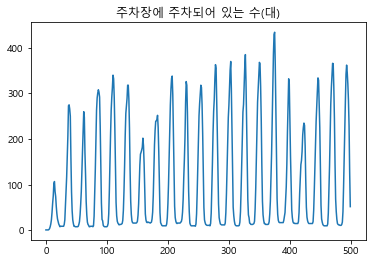

In [7]:
y['parked'][:500].plot()
plt.title('주차장에 주차되어 있는 수(대)')
plt.show()

In [8]:
data_s=pd.DataFrame(data_scaled)
train_s=pd.DataFrame(train_scaled)
train_parked=y_train['parked']
test_parked=y_test['parked']
parked=y['parked'][:-1]

In [9]:
print(train_parked.shape,test_parked.shape,parked.shape)

(1800,) (360,) (2160,)


**PCA**  \
시계열 데이터의 외부변수는 상관관계가 높지 않는 것이 좋기 때문에 PCA를 통해 상관관계가 0인 변수들을 사용

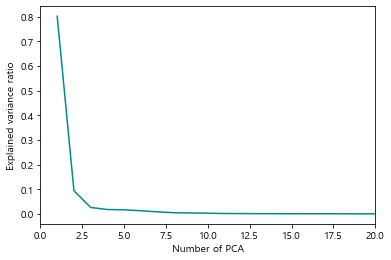

In [16]:
pca=PCA().fit(train_s) 

plt.plot(np.arange(1,train_s.shape[1]+1), pca.explained_variance_ratio_,color='darkcyan')
plt.xlabel('Number of PCA')
plt.ylabel('Explained variance ratio')
plt.xlim(0,20)
plt.show()

In [17]:
pca = PCA(n_components=3) 
train_pca= pca.fit_transform(train_s)
test_pca= pca.transform(test_scaled)
data_pca= pca.transform(data_scaled)

In [18]:
train_pca=pd.DataFrame(train_pca)
test_pca=pd.DataFrame(test_pca)
data_pca=pd.DataFrame(data_pca)

In [19]:
train_pca.shape

(1800, 3)

In [20]:
train_pca

,0,1,2
0,-6.005160,-1.055570,-0.543311
1,-6.009211,-1.053979,-0.538972
2,-6.032112,-1.037060,-0.567657
3,-6.043164,-1.029183,-0.586563
4,-6.032379,-1.033478,-0.581303
...,...,...,...
1795,-1.816329,2.159575,1.669746
1796,-3.068301,1.433439,1.369457
1797,-3.825420,0.993444,0.967423
1798,-4.505061,0.644591,0.562286


**시간 변수 추가** \
시계열 데이터의 시계열적인 특성을 부각하기 위해 시간대별, 요일별 더미 변수, 시간대별 차분 변수를 추가해주었다.

In [21]:
def timestamp(x,data2,a='day',b='hour'):
    ind=x.index.tolist()
    x=x.reset_index(drop=True)
    x['date']=pd.to_datetime(x.date)
    x[a]=x.date.dt.dayofweek
    x[b]=x.date.dt.hour
    
    def times(c):
        if c in [1,2,3]:
            return('새벽A')
        elif c in [4,5,6]:
            return('새벽B')
        elif c in [7,8,9]:
            return('아침A')
        elif c in [10,11,12]:
            return('아침B')
        elif c in [13,14,15]:
            return('오후A')
        elif c in [16,17,18]:
            return('오후B')
        elif c in [19,20,21]:
            return('저녁A')
        else:
            return('저녁B')
    
    x['시간대'] = x[b].apply(times)
    
    for i in [a,b,'시간대']:
        globals()['dummy_'+str(i)] = pd.get_dummies(x[i])
        if i ==a:
            globals()['dummy_'+str(i)].columns=['월','화','수','목','금','토','일']
        elif i==b:
            globals()['dummy_'+str(i)].columns=[str(x)+'시' for x in range(24)]
        data2=pd.concat([data2,globals()['dummy_'+str(i)]],axis=1)
    

    
    
    #display(data2['parked_shifted_48'])
    data2=data2.dropna()

    return data2

train_data2=timestamp(train_data,train_pca,'day','hour')
test_data2=timestamp(test_data,test_pca,'day','hour')
data2=timestamp(data,data_pca,'day','hour')

In [22]:
df=pd.DataFrame(np.zeros(360))

In [23]:
train_data22=train_data2.iloc[:,3:]

In [24]:
test_data22=test_data2.iloc[:,3:]

In [25]:
data22=data2.iloc[:,3:]

In [26]:
start_date = datetime.strptime('2021-04-01 00:00', '%Y-%m-%d %H:%M') 
end_date = datetime.strptime('2021-04-16 00:00', '%Y-%m-%d %H:%M') 

# 날짜를 입력할 리스트 
str_date_list = [] 

while start_date.strftime('%Y-%m-%d %H:%M') != end_date.strftime('%Y-%m-%d %H:%M'): 
    str_date_list.append(start_date.strftime('%Y-%m-%d %H:%M')) 
    start_date += timedelta(hours=1) 



In [27]:
df['date']=str_date_list

In [28]:
submit_data=timestamp(data,df,'day','hour')

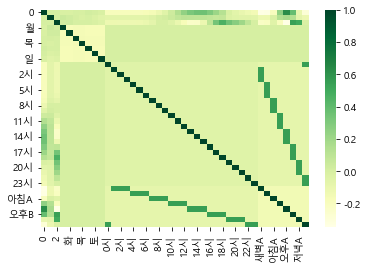

In [31]:
sns.heatmap(train_data2.corr(),cmap='YlGn')
plt.show()

In [41]:
data2.to_csv('data/dataplus2.csv',index=False)

In [239]:
train_data2.to_csv('data/train_data2.csv',index=False)
test_data2.to_csv('data/test_data2.csv',index=False)

## 3. Time Series

**시계열 분해**


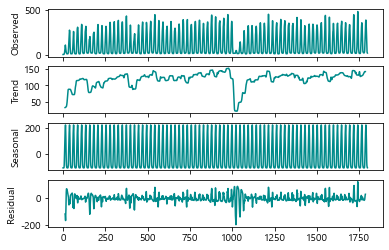

In [10]:
decomposition = seasonal_decompose(train_parked, model='additive', period=24)

fig, axes = plt.subplots(4, 1, sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False, color='darkcyan')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='darkcyan')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='darkcyan')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='darkcyan')
axes[3].set_ylabel('Residual')
plt.show()

**정상성 검증(ADF검정)**

In [11]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=120).mean()
    rolstd = timeseries.rolling( window=120).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='darkcyan',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

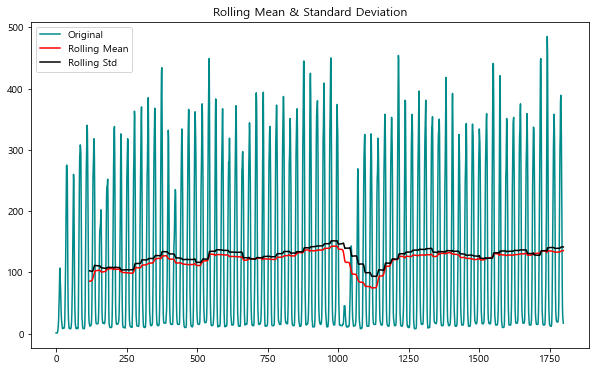

<Results of Dickey-Fuller Test>
Test Statistic                   -4.929922
p-value                           0.000030
#Lags Used                       25.000000
Number of Observations Used    1774.000000
Critical Value (1%)              -3.434042
Critical Value (5%)              -2.863171
Critical Value (10%)             -2.567638
dtype: float64


In [12]:
test_stationarity(train_parked)

**차분진행**

C:\Users\sktmd\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


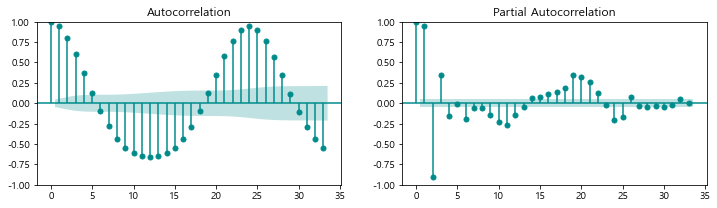

In [13]:
#PACF와 ACF 그래프를 통해 적절한 차수 탐색

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(train_parked,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(train_parked, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')

plt.show()

In [14]:
y_train['diff']=y_train['parked'].diff(24)
diffed=y_train['diff'].dropna()
y_test['diff']=y_test['parked'].diff(24)
test_diffed=y_test['diff'].dropna()

C:\Users\sktmd\AppData\Local\Temp/ipykernel_29292/240628255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['diff']=y_train['parked'].diff(24)
C:\Users\sktmd\AppData\Local\Temp/ipykernel_29292/240628255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['diff']=y_test['parked'].diff(24)


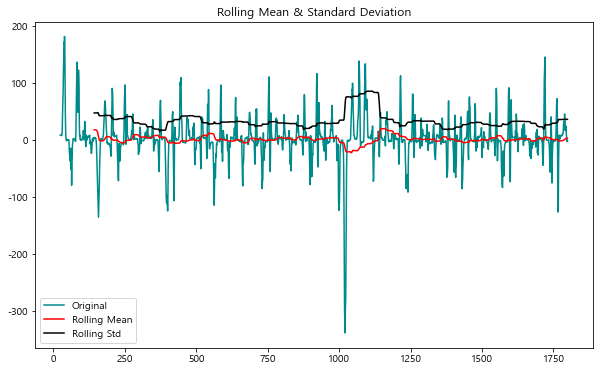

<Results of Dickey-Fuller Test>
Test Statistic                -8.971953e+00
p-value                        7.711089e-15
#Lags Used                     2.500000e+01
Number of Observations Used    1.750000e+03
Critical Value (1%)           -3.434092e+00
Critical Value (5%)           -2.863193e+00
Critical Value (10%)          -2.567650e+00
dtype: float64


In [15]:
#차분 후, 정상성이 있는 시계열로 변환하였다.

test_stationarity(diffed)

**계절성 차분** \
48시간을 주기로 기댓값이 변화하는 모습이 보여 계절성 차분을 진행한다.

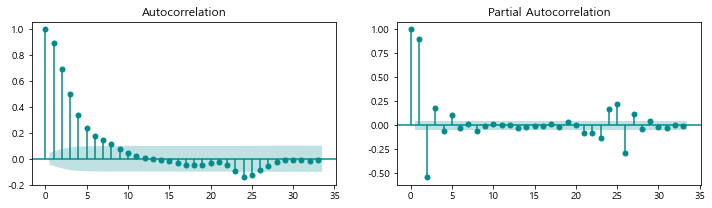

In [22]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(diffed,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(diffed, ax=axes[1],color='darkcyan',vlines_kwargs={"colors":'darkcyan'} )

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

In [23]:
#계절성 차분
y_train['seasonal_first_difference'] = y_train['diff'] - y_train['diff'].shift(48)  
y_test['seasonal_first_difference'] = y_test['diff'] - y_test['diff'].shift(48)  

<ipython-input-23-7dbc3142f215>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['seasonal_first_difference'] = y_train['diff'] - y_train['diff'].shift(48)
<ipython-input-23-7dbc3142f215>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['seasonal_first_difference'] = y_test['diff'] - y_test['diff'].shift(48)


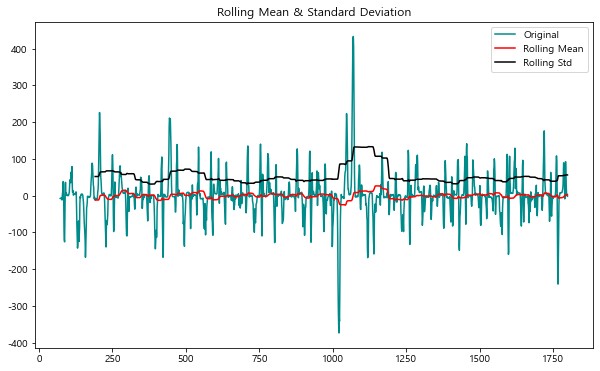

<Results of Dickey-Fuller Test>
Test Statistic                -7.359051e+00
p-value                        9.607812e-11
#Lags Used                     2.500000e+01
Number of Observations Used    1.702000e+03
Critical Value (1%)           -3.434198e+00
Critical Value (5%)           -2.863240e+00
Critical Value (10%)          -2.567675e+00
dtype: float64


In [24]:
test_stationarity(y_train.seasonal_first_difference.dropna(inplace=False))

In [25]:
season_diff=y_train.seasonal_first_difference.dropna(inplace=False)

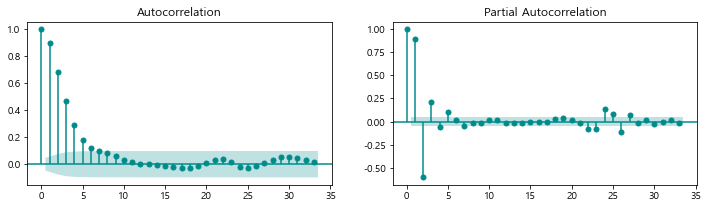

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(season_diff,ax=axes[0],color='darkcyan',vlines_kwargs={"colors":'darkcyan'})
plot_pacf(season_diff, ax=axes[1],color='darkcyan',vlines_kwargs={"colors": 'darkcyan'})

for item in axes[0].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
        
for item in axes[1].collections:
    if type(item)==PolyCollection:
        item.set_facecolor('darkcyan')
plt.show()

**로그변환**

In [36]:
train_park=np.log(train_parked)

In [37]:
test_park=np.log(test_parked)

In [38]:
park = np.log(parked)

### ARIMA

**Auto Arima** 
- 차수를 조절하며 AIC를 최소로 하는 최적의 차수를 찾는 방법 
- 평가지표: AUC

In [39]:
from pmdarima.arima import auto_arima

model_arima= auto_arima(train_park,X=train_data22,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=True)

model_arima.fit(parked)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-2947.744, Time=12.39 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-3108.195, Time=12.63 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-3112.559, Time=13.55 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-3110.564, Time=13.57 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-2381.843, Time=11.36 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-2792.689, Time=13.55 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-2920.447, Time=14.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=13.61 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-2557.125, Time=13.04 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-2365.601, Time=12.76 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-2776.168, Time=13.65 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-2424.423, Time=15.57 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=-2663.946, Time=13.89 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=-3109.712, Time=13.57 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=-3115.793, T

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

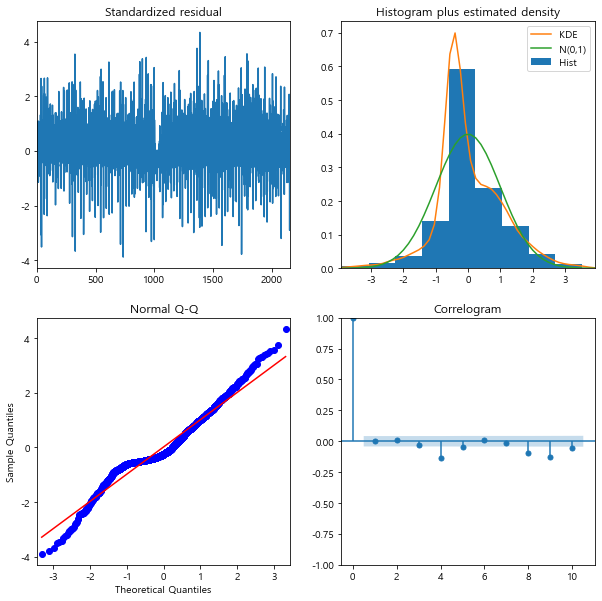

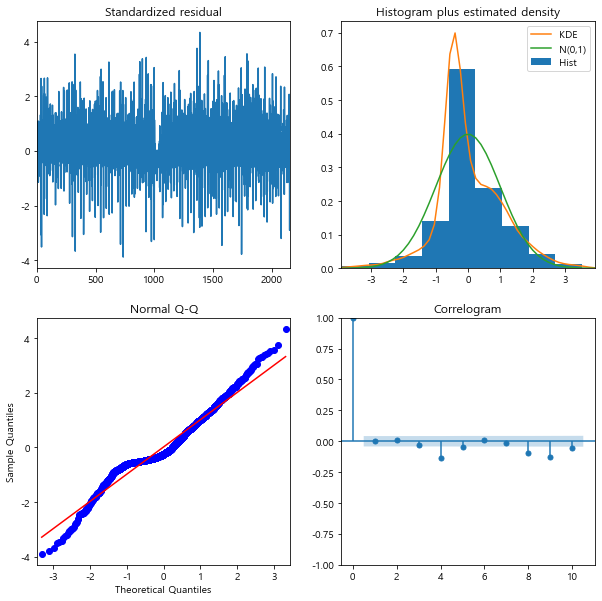

In [40]:
model_arima.plot_diagnostics(figsize=(10,10))

**SARIMAX**
- SARIMA: arima 모델에 계절성 성분이 추가된 모델로 데이터의 주기(M)의 정보를 활용
- SARIMAX: 기존의 SARIMA모델에 외부 변수를 활용

In [117]:
arimax = sm.tsa.statespace.sarimax.SARIMAX(train_park,order=(3,1,2),seasonal_order=(3,1,2,48),exog = train_data22,
                                  enforce_stationarity=False, enforce_invertibility=False,n_jobs=-1).fit()
arimax.summary()

C:\Users\sktmd\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             parked   No. Observations:                 1800
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 48)   Log Likelihood                1450.936
Date:                            Sat, 05 Jun 2021   AIC                          -2801.871
Time:                                    12:38:07   BIC                          -2532.859
Sample:                                         0   HQIC                         -2701.991
                                           - 1800                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
월             -0.0182      0.024     -0.751      0.452      -0.066       0.029
화              0.0365      0.027      1.369      0.171      -0.016       0.089
수              0.0270      0.027      1.015      0.310      -0.025       0.079
목              0.0147      0.028      0.516      0.606      -0.041       0.070
금             -0.0182      0.025     -0.715      0.474      -0.068       0.032
토             -0.0335      0.024     -1.371      0.170      -0.081       0.014
일             -0.0094      0.024     -0.390      0.696      -0.057       0.038
0시         -1.215e-08   3.14e-07     -0.039      0.969   -6.27e-07    6.03e-07
1시          4.971e-09    1.7e-07      0.029      0.977   -3.29e-07    3.39e-07
2시         -1.451e-08   4.04e-08     -0.359      0.720   -9.38e-08    6.48e-08
3시          1.066e-08   3.29e-07      0.032      0.974   -6.35e-07    6.56e-07
4시          6.771e-09   1.03e-06      0.007      0.995      -2e-06    2.02e-06
5시         -3.827e-08   1.28e-06     -0.030      0.976   -2.56e-06    2.48e-06
6시         -5.678e-08   1.64e-06     -0.035      0.972   -3.28e-06    3.17e-06
7시          4.772e-08   9.61e-07      0.050      0.960   -1.84e-06    1.93e-06
8시          2.767e-08   3.89e-08      0.712      0.476   -4.85e-08    1.04e-07
9시          1.103e-08   2.11e-07      0.052      0.958   -4.03e-07    4.25e-07
10시        -2.059e-08   4.28e-07     -0.048      0.962   -8.59e-07    8.17e-07
11시        -3.237e-09   4.31e-07     -0.008      0.994   -8.47e-07    8.41e-07
12시         2.592e-09   2.03e-07      0.013      0.990   -3.94e-07       4e-07
13시         8.715e-09   7.84e-08      0.111      0.911   -1.45e-07    1.62e-07
14시          2.72e-08   1.79e-07      0.152      0.879   -3.24e-07    3.79e-07
15시        -9.085e-09   8.38e-08     -0.108      0.914   -1.73e-07    1.55e-07
16시        -1.501e-08   4.76e-08     -0.315      0.753   -1.08e-07    7.84e-08
17시        -1.067e-08   1.55e-07     -0.069      0.945   -3.15e-07    2.94e-07
18시        -1.002e-08   3.72e-07     -0.027      0.979    -7.4e-07     7.2e-07
19시         4.072e-08   4.25e-07      0.096      0.924   -7.93e-07    8.74e-07
20시         2.846e-08   2.03e-07      0.140      0.889    -3.7e-07    4.26e-07
21시        -8.557e-10   3.52e-07     -0.002      0.998    -6.9e-07    6.88e-07
22시        -1.661e-08   5.49e-07     -0.030      0.976   -1.09e-06    1.06e-06
23시         2.219e-09   7.43e-07      0.003      0.998   -1.45e-06    1.46e-06
새벽A         1.232e-09   1.17e-07      0.010      0.992   -2.29e-07    2.31e-07
새벽B        -8.831e-08   1.38e-06     -0.064      0.949    -2.8e-06    2.63e-06
아침A         8.661e-08   7.88e-07      0.110      0.912   -1.46e-06    1.63e-06
아침B        -2.108e-08   6.56e-07     -0.032      0.974   -1.31e-06    1.26e-06
오후A         2.688e-08   1.74e-07      0.155      0.877   -3.14e-07    3.68e-07
오후B        -3.579e-08   1.69e-07     -0.211      0.8

In [309]:
arimax.aic

-3035.998026444712

In [154]:
fcast_arima = arimax.predict(1800,1799+test_data2.shape[0],dynamic=False,exog=test_data22)

In [140]:
fcast_arima1=np.exp(fcast_arima)

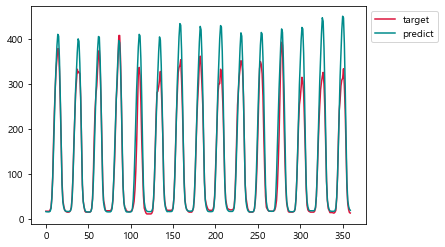

In [310]:
test_parked.reset_index(drop=True).plot(color='crimson')
pd.Series(fcast_arima1).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['target','predict'],bbox_to_anchor=(1,1))

In [126]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_parked, fcast_arima1)

0.04363944642650775

**Test**

In [253]:
fcast_arima1.index=data['date'][1800:]

In [256]:
train_parked.index=data['date'][:1800]

In [316]:
parked.index=data['date']

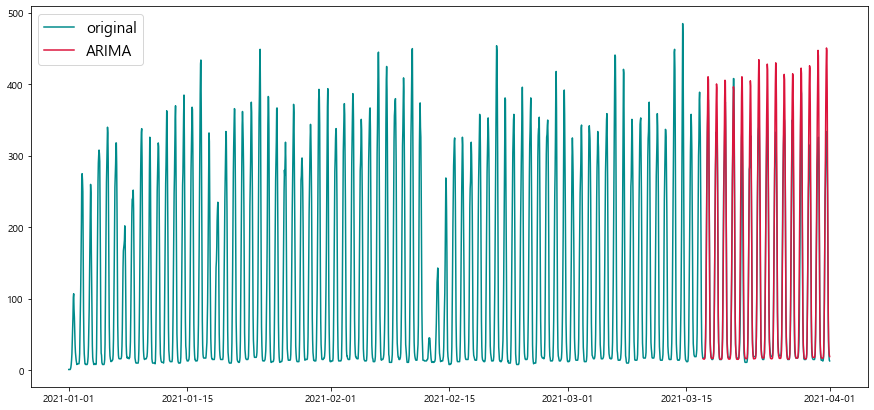

In [317]:
plt.figure(figsize=(15,7))
line1, = plt.plot(parked,  color='darkcyan')
#line2, = plt.plot(arimax.fittedvalues, marker='o', color='blue')
line3, = plt.plot(fcast_arima1,  color='crimson')
plt.legend([line1, line3],['original', 'ARIMA'],fontsize=15)
plt.show()

**Ensemble** \
ARIMA와 LSTM의 예측값 앙상블

In [33]:
minmax=pd.read_csv('data/LSTM_0.042.csv')

In [130]:
arim=fcast_arima1.reset_index(drop=True)

In [131]:
lstm=minmax['y_pred']

In [178]:
preds = [arim, lstm]

In [190]:
p = 2.57
p = (np.sum(np.array(preds)**p, axis=0) / len(preds))**(1/p)

In [193]:
p=arim*0.2+lstm*0.8

In [186]:
from scipy.stats.mstats import gmean
p=gmean([arim,lstm])

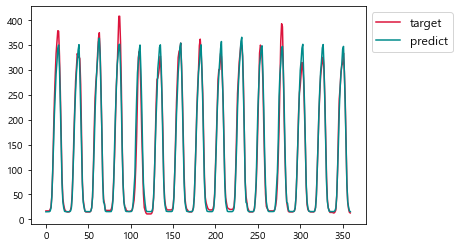

In [309]:
test_parked.reset_index(drop=True).plot(color='crimson')
pd.Series(p).reset_index(drop=True).plot(color='darkcyan')
plt.legend(['target','predict'],fontsize=12,bbox_to_anchor=(1,1))

In [195]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_parked, p)

0.034092147537529975

## Predict
**4월 이후 15일 예측**

In [414]:
parked

date
2021-01-01 00:00:00     1
2021-01-01 01:00:00     1
2021-01-01 02:00:00     1
2021-01-01 03:00:00     1
2021-01-01 04:00:00     1
                       ..
2021-03-16 19:00:00    83
2021-03-16 20:00:00    41
2021-03-16 21:00:00    27
2021-03-16 22:00:00    21
2021-03-16 23:00:00    17
Name: parked, Length: 1800, dtype: int64

In [51]:
park=np.log(parked[48:])

In [156]:
data2.shape

(2160, 42)

In [163]:
final_arimax = sm.tsa.statespace.sarimax.SARIMAX(park,order=(2,1,3),seasonal_order=(2,1,3,48),exog = data22,
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
final_arimax.summary()

C:\Users\sktmd\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             parked   No. Observations:                 2160
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 48)   Log Likelihood                1880.376
Date:                            Sat, 05 Jun 2021   AIC                          -3660.752
Time:                                    15:40:04   BIC                          -3381.641
Sample:                                         0   HQIC                         -3558.171
                                           - 2160                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
월             -0.0158      0.020     -0.785      0.432      -0.055       0.024
화              0.0339      0.022      1.516      0.130      -0.010       0.078
수              0.0268      0.023      1.179      0.238      -0.018       0.071
목              0.0200      0.025      0.804      0.421      -0.029       0.069
금             -0.0117      0.021     -0.548      0.584      -0.053       0.030
토             -0.0376      0.019     -1.940      0.052      -0.076       0.000
일             -0.0174      0.020     -0.877      0.380      -0.056       0.021
0시          9.765e-10   1.02e-11     95.544      0.000    9.56e-10    9.97e-10
1시         -2.621e-10   3.11e-11     -8.420      0.000   -3.23e-10   -2.01e-10
2시         -6.626e-10   6.49e-12   -102.134      0.000   -6.75e-10    -6.5e-10
3시          -1.11e-11   2.21e-11     -0.502      0.616   -5.44e-11    3.22e-11
4시         -2.566e-10   1.12e-10     -2.299      0.022   -4.75e-10   -3.78e-11
5시          4.435e-10   5.74e-11      7.729      0.000    3.31e-10    5.56e-10
6시         -9.263e-10   1.65e-10     -5.621      0.000   -1.25e-09   -6.03e-10
7시          8.868e-10   1.29e-10      6.872      0.000    6.34e-10    1.14e-09
8시         -4.663e-10    3.3e-11    -14.140      0.000   -5.31e-10   -4.02e-10
9시          4.731e-10   7.31e-11      6.475      0.000     3.3e-10    6.16e-10
10시        -1.279e-10   2.33e-11     -5.497      0.000   -1.74e-10   -8.23e-11
11시        -7.474e-10   5.11e-11    -14.635      0.000   -8.48e-10   -6.47e-10
12시         2.238e-10   7.19e-12     31.110      0.000     2.1e-10    2.38e-10
13시        -5.453e-11   3.65e-11     -1.495      0.135   -1.26e-10     1.7e-11
14시        -1.514e-10   5.36e-11     -2.825      0.005   -2.56e-10   -4.64e-11
15시        -1.305e-10   2.49e-11     -5.252      0.000   -1.79e-10   -8.18e-11
16시        -3.449e-10   2.43e-11    -14.202      0.000   -3.92e-10   -2.97e-10
17시        -1.356e-10   7.64e-11     -1.774      0.076   -2.85e-10    1.42e-11
18시        -6.052e-11   2.76e-10     -0.219      0.827   -6.02e-10    4.81e-10
19시         2.266e-10   2.51e-10      0.904      0.366   -2.65e-10    7.18e-10
20시         4.167e-10    2.3e-10      1.813      0.070   -3.39e-11    8.67e-10
21시        -3.442e-10    3.3e-10     -1.042      0.298   -9.92e-10    3.03e-10
22시        -6.166e-10   1.13e-10     -5.466      0.000   -8.38e-10   -3.96e-10
23시        -5.188e-10   9.05e-11     -5.731      0.000   -6.96e-10   -3.41e-10
새벽A        -3.731e-10   5.86e-11     -6.362      0.000   -4.88e-10   -2.58e-10
새벽B        -2.325e-10    9.4e-11     -2.474      0.013   -4.17e-10   -4.83e-11
아침A          6.92e-10    1.5e-10      4.606      0.000    3.98e-10    9.86e-10
아침B        -1.581e-10   6.79e-11     -2.329      0.020   -2.91e-10   -2.51e-11
오후A         1.412e-10    1.2e-11     11.732      0.000    1.18e-10    1.65e-10
오후B        -4.787e-10   1.87e-10     -2.565      0.0

In [162]:
data2

,0,1,2,월,화,수,목,금,토,일,...,22시,23시,새벽A,새벽B,아침A,아침B,오후A,오후B,저녁A,저녁B
0,-3.110394,-0.679085,-0.245694,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-3.114684,-0.678152,-0.230430,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-3.141827,-0.662081,-0.250119,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,-3.155044,-0.654791,-0.266907,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-3.141815,-0.657573,-0.266448,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,-0.208314,1.493043,0.879637,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2156,-0.930094,1.178397,0.842027,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2157,-1.385143,1.016018,0.657614,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2158,-1.785744,0.893676,0.509640,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [165]:
final_arima = final_arimax.predict(2160,2519,dynamic=False,exog=submit_data.iloc[:,2:])

In [166]:
final_arima=np.exp(final_arima)

In [170]:
final_lstm=pd.read_csv('data/LSTM_April.csv')

In [322]:
final_lstm.index=[i for i in range(2160,2520)]

<AxesSubplot:>

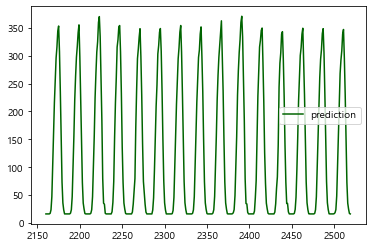

In [323]:
final_lstm.plot(color='darkgreen')

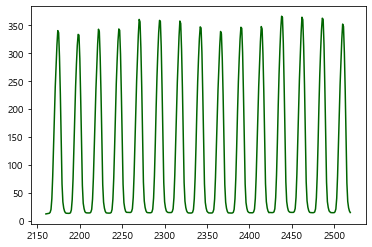

In [321]:
final_arima.index=[i for i in range(2160,2520)]
final_arima.plot(color='darkgreen')
plt.show()

In [173]:
final_preds = [final_arima, final_lstm]

In [324]:
p=final_arima*0.2+final_lstm['prediction']*0.8

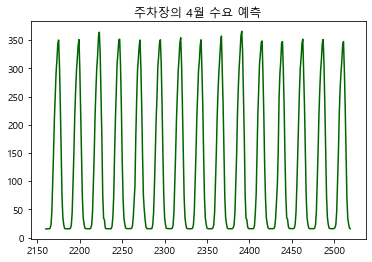

In [325]:
p.plot(color='darkgreen')
plt.title('주차장의 4월 수요 예측')
plt.show()

In [330]:
p.index=df['date']

In [335]:
parked.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-03-31 14:00:00', '2021-03-31 15:00:00',
               '2021-03-31 16:00:00', '2021-03-31 17:00:00',
               '2021-03-31 18:00:00', '2021-03-31 19:00:00',
               '2021-03-31 20:00:00', '2021-03-31 21:00:00',
               '2021-03-31 22:00:00', '2021-03-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=2160, freq=None)

In [338]:
p.index=pd.to_datetime(p.index)

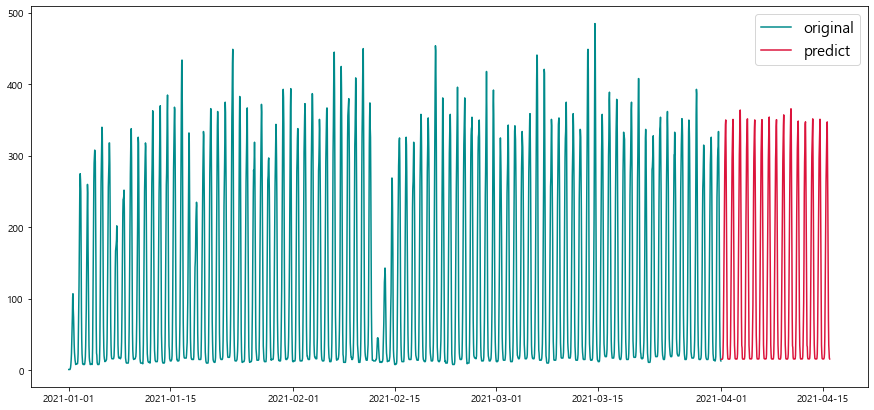

In [340]:
plt.figure(figsize=(15,7))
line1, = plt.plot(parked,  color='darkcyan')
#line2, = plt.plot(arimax.fittedvalues, marker='o', color='blue')
line3, = plt.plot(p,  color='crimson')
plt.legend([line1, line3],['original', 'predict'],fontsize=15)
plt.show()